## 1. Генерація тексту (https://keras.io/examples/generative/lstm_character_level_text_generation/)

In [47]:
import keras
from keras import layers

import numpy as np
import random
import io

In [48]:
path = keras.utils.get_file(
    "book.txt",
    origin="https://www.gutenberg.org/files/11/11-0.txt",
)
with io.open(path, encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")  # We remove newlines chars for nicer display
print("Corpus length:", len(text))

chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype="bool")
y = np.zeros((len(sentences), len(chars)), dtype="bool")
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Corpus length: 164047
Total chars: 63
Number of sequences: 54669


In [49]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.1)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [50]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [51]:
epochs = 10
batch_size = 64

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.1, 0.5, 1.0]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        for i in range(200):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print("-")

855/855 [==============================] - 91s 102ms/step - loss: 4.4559

Generating text after epoch: 0
...Diversity: 0.1
...Generating with seed: "ut the whiting!”  “oh, as to the whiting"
...Generated:   sellelleellensellelless shessensellessellellesselless she herme hermere she herme she she herme herme herme she hermemessellessellessensellelleesellessenseellessellellellessent she she hermere she sh
-
...Diversity: 0.5
...Generating with seed: "ut the whiting!”  “oh, as to the whiting"
...Generated:   sening sens, shesserle alice themes wormermeck mase herilled meneamenle she mermeellen,” said all you the meel cever wellenellemon not, theme all hermemeenenlelly chermerkecs she shemenn went ishes w
-
...Diversity: 1.0
...Generating with seed: "ut the whiting!”  “oh, as to the whiting"
...Generated:  hel, her me,” sheselhion.”  “me wessing ingtesdeel!yy!”  “ill,” shenilasoms!”  “ghermem_. hagh!” she shes chensseeleslesly mens thell ecentiel,” she here maedt, leminyrermenen!”  “yames 

## 2. HF Transformers

In [52]:
# Transformers installation
#pip install transformers

from transformers import pipeline
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [53]:
text_1 = '''Скажи мені, чому не можу
Забути те, чого нема
Скажи мені, чому не можу
Забути те, що... те, що навколо зима'''
classifier(text_1)

[{'label': 'NEGATIVE', 'score': 0.9559538960456848}]

In [54]:
text_2 = '''Що танцюють на голові
Та тримають небо на долонях
Що танцюють на голові
Та тримають небо на долонях
Що танцюють на головах
Та тримають небо на долонях
Що танцюють на головах
Та тримають небо на руках'''
classifier(text_2)

[{'label': 'NEGATIVE', 'score': 0.9364068508148193}]

Україномовна модель (використовувалась lb-2 https://huggingface.co/ukr-models/lb-2)

In [55]:
from transformers import AutoTokenizer, AutoModel
import torch

In [56]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [57]:
sentences = ['''Але стіна твоїх очей
Втопить мене в блиску ночей –
Дихати не дасть її тепло
Темна вода хвилю жене
Але мене не дожене
Хвиля твоя. Я іду на дно...''',
             '''Шукай в телефоні мій слід
Цілуй в вікно мої губи
Як знак на моєму плечі ти квітка, ти квітка
Шукай в телефоні мій слід
Цілуй в вікно мої губи
Так швидко в моєму житті
Так швидко ти квітка''',
             '''Гей, чому я, чому я
Зупинитися не зміг?
Як мене збивають з ніг
Знов і знов збивають з ніг
Твої зелені очі''',
             '''Спи собі сама
Коли біля тебе мене нема
Спи собі сама
Коли біля тебе мене нема
Спи собі сама
Коли біля тебе мене нема
Спи собі сама
Коли біля тебе мене нема''',
             '''не плач, моє серце, не плач,
не муч душу свою картонну,
ми ще зустрінемось
з того боку кордону.

з того боку життя,
з того боку державної митниці.
ми ще побачимось
де-небудь в районі Вінниці.

я люблю цю країну
навіть без кокаїну,
небо це березневе,
без тебе, серце, без тебе.

кину все, що виніс,
перепродам свій бізнес,
вийду на берег Дунаю,
там і сконаю.''']

In [58]:
tokenizer = AutoTokenizer.from_pretrained('ukr-models/lb-2')
model = AutoModel.from_pretrained('ukr-models/lb-2')

In [59]:
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

In [60]:
with torch.no_grad():
    model_output = model(**encoded_input)

In [61]:
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [62]:
print("Sentence embeddings:")
print(sentence_embeddings)

Sentence embeddings:
tensor([[ 0.2762,  0.3186,  0.3357,  ..., -0.6250,  0.3764, -0.5814],
        [ 0.4188,  0.3718,  0.3935,  ..., -0.3513,  0.2309, -0.3018],
        [ 0.1355,  0.2967,  0.3609,  ..., -0.7394,  0.0349, -0.1049],
        [ 0.4403,  0.4041,  0.2927,  ..., -0.3516,  0.1251, -0.2225],
        [ 0.3775,  0.2015,  0.5714,  ..., -0.3838,  0.5199, -0.1354]])


In [63]:
print(sentences[0], ' : ', classifier(sentences[0]))
print(sentences[1], ' : ', classifier(sentences[1]))
print(sentences[2], ' : ', classifier(sentences[2]))
print(sentences[3], ' : ', classifier(sentences[3]))
print(sentences[4], ' : ', classifier(sentences[4]))

Але стіна твоїх очей
Втопить мене в блиску ночей –
Дихати не дасть її тепло
Темна вода хвилю жене
Але мене не дожене
Хвиля твоя. Я іду на дно...  :  [{'label': 'NEGATIVE', 'score': 0.6532756686210632}]
Шукай в телефоні мій слід
Цілуй в вікно мої губи
Як знак на моєму плечі ти квітка, ти квітка
Шукай в телефоні мій слід
Цілуй в вікно мої губи
Так швидко в моєму житті
Так швидко ти квітка  :  [{'label': 'NEGATIVE', 'score': 0.8860889673233032}]
Гей, чому я, чому я
Зупинитися не зміг?
Як мене збивають з ніг
Знов і знов збивають з ніг
Твої зелені очі  :  [{'label': 'NEGATIVE', 'score': 0.9249182343482971}]
Спи собі сама
Коли біля тебе мене нема
Спи собі сама
Коли біля тебе мене нема
Спи собі сама
Коли біля тебе мене нема
Спи собі сама
Коли біля тебе мене нема  :  [{'label': 'NEGATIVE', 'score': 0.9313781261444092}]
не плач, моє серце, не плач,
не муч душу свою картонну,
ми ще зустрінемось
з того боку кордону.

з того боку життя,
з того боку державної митниці.
ми ще побачимось
де-небудь в р

## 3. Копіювання стилю (https://keras.io/examples/generative/neural_style_transfer/)

In [64]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19

base_image_path = keras.utils.get_file("main.jpg", "https://cdn3.whatculture.com/images/2014/01/Tony-Stark.jpg")
style_reference_image_path = keras.utils.get_file(
    "style.jpg", "https://assets.xboxservices.com/assets/43/79/4379ece7-a52b-4f6a-93c4-8880683b5f26.jpg?n=Cyberpunk-2077_Gallery-0_1350x759_10.jpg"
)
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

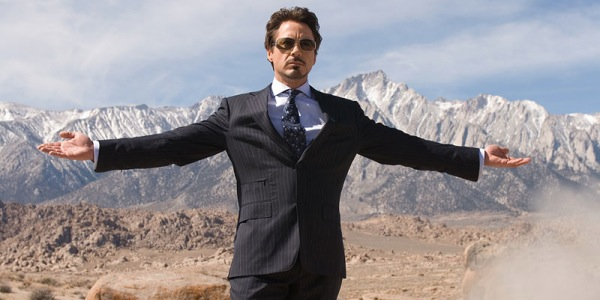

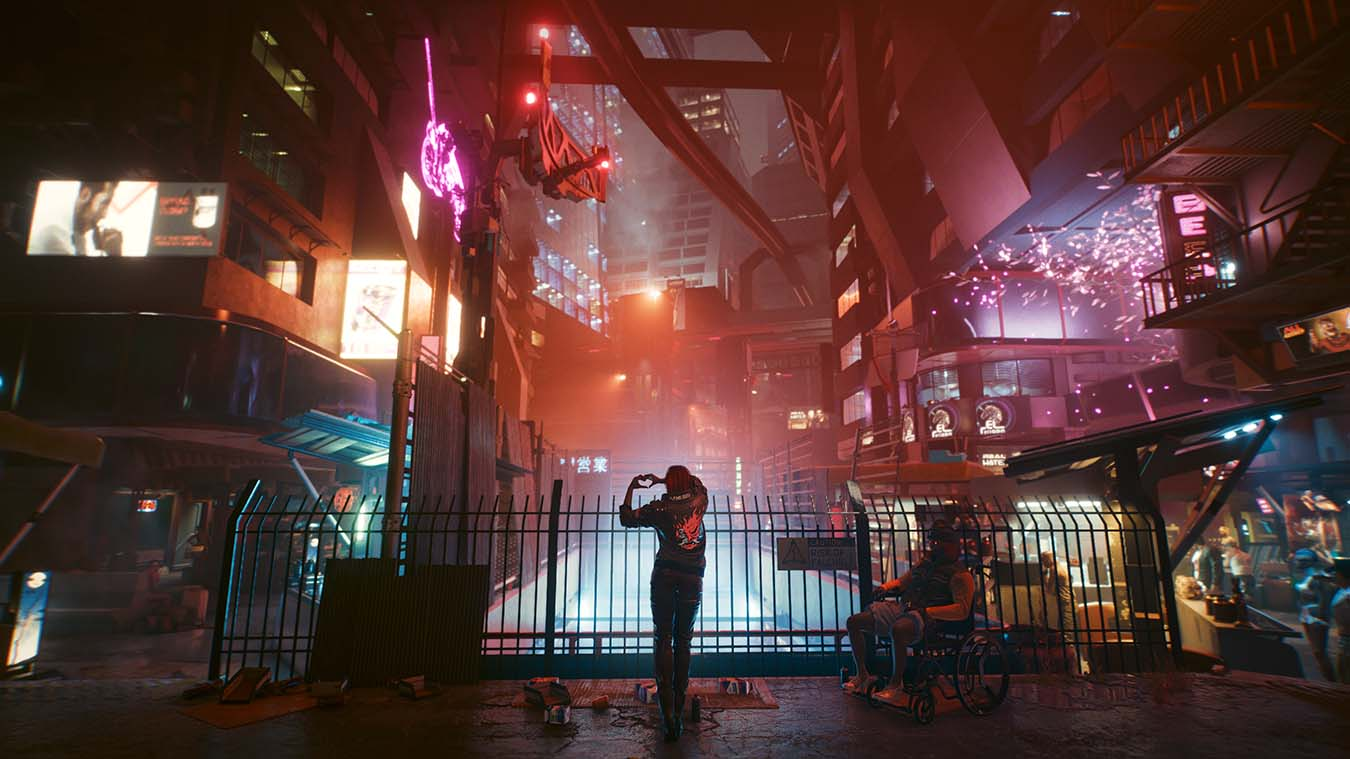

In [65]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [66]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [67]:
model = vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [68]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [69]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [70]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.90
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 500
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 1 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 1: loss=41502.09
Iteration 2: loss=33223.31
Iteration 3: loss=23634.17
Iteration 4: loss=17050.05
Iteration 5: loss=13245.44
Iteration 6: loss=11340.49
Iteration 7: loss=10205.95
Iteration 8: loss=9391.22
Iteration 9: loss=8760.33
Iteration 10: loss=8251.37
Iteration 11: loss=7831.38
Iteration 12: loss=7478.25
Iteration 13: loss=7175.74
Iteration 14: loss=6913.82
Iteration 15: loss=6684.98
Iteration 16: loss=6482.41
Iteration 17: loss=6302.08
Iteration 18: loss=6140.61
Iteration 19: loss=5995.01
Iteration 20: loss=5863.15
Iteration 21: loss=5742.75
Iteration 22: loss=5632.37
Iteration 23: loss=5530.72
Iteration 24: loss=5436.53
Iteration 25: loss=5349.23
Iteration 26: loss=5267.76
Iteration 27: loss=5191.62
Iteration 28: loss=5120.00
Iteration 29: loss=5052.64
Iteration 30: loss=4989.07
Iteration 31: loss=4929.08
Iteration 32: loss=4872.16
Iteration 33: loss=4818.10
Iteration 34: loss=4766.70
Iteration 35: loss=4717.72
Iteration 36: loss=4670.91
Iteration 37: loss=4626.13
Ite

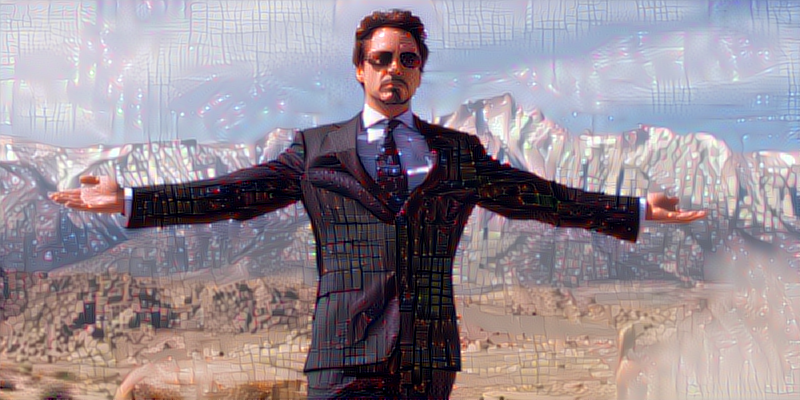

In [71]:
display(Image(result_prefix + "_at_iteration_500.png"))